In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tabulate import tabulate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectFromModel


XGBoostError: 
XGBoost Library (libxgboost.dylib) could not be loaded.
Likely causes:
  * OpenMP runtime is not installed
    - vcomp140.dll or libgomp-1.dll for Windows
    - libomp.dylib for Mac OSX
    - libgomp.so for Linux and other UNIX-like OSes
    Mac OSX users: Run `brew install libomp` to install OpenMP runtime.

  * You are running 32-bit Python on a 64-bit OS

Error message(s): ["dlopen(/Users/tizianapelamatti/Library/Python/3.9/lib/python/site-packages/xgboost/lib/libxgboost.dylib, 0x0006): Library not loaded: @rpath/libomp.dylib\n  Referenced from: <FBD6AEF9-AFAB-39D7-B881-755157DA0497> /Users/tizianapelamatti/Library/Python/3.9/lib/python/site-packages/xgboost/lib/libxgboost.dylib\n  Reason: tried: '/usr/local/opt/libomp/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/usr/local/opt/libomp/lib/libomp.dylib' (no such file), '/usr/local/opt/libomp/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/usr/local/opt/libomp/lib/libomp.dylib' (no such file)"]


In [17]:
labels = pd.read_csv('marksheet.csv')
dataset = pd.read_csv('PI-CAI_features.csv')

print(dataset.shape)

# Filter the dataset to include only AI annotations and t2w sequences and ROI lesion
filtered_dataset = dataset[dataset['annotator'] == 'AI']
filtered_dataset = filtered_dataset[filtered_dataset['sequence'] == 't2w']
filtered_dataset = filtered_dataset[filtered_dataset['ROI'] == 'lesion']
filtered_dataset.drop(columns=['annotator', 'sequence', 'ROI_ID', 'ROI','img_path', 'seg_path', 'extraction_ID'], inplace=True)
dataset = filtered_dataset

# Rename columns to match the labels dataset
labels.rename(columns={'patient_id': 'patient_ID', 'study_id': 'study_ID'}, inplace=True)

# We only want Magnetic Resonace Biopsy (MRBx) labels because Systematic Biopsy (SBx) labels are not for our usecase
# we also remove those that have both because clicinians result might be biased
#labels = labels[labels['histopath_type'] == 'MRBx']

# Remove useless columns from labels dataset
labels.drop(columns=['mri_date', 'histopath_type', 'center', 'lesion_ISUP', 'lesion_GS'], inplace=True)

# Rename Yes to 1 and No to 0 in the labels dataset
labels.case_csPCa = labels.case_csPCa.map(lambda x: 1 if x == 'YES' else 0)

(6288, 1024)


In [18]:
labels.dropna(inplace=True)

In [19]:
corr_matrix = dataset.drop(columns=['study_ID', 'patient_ID']).corr().abs()

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))


to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]

dataset.drop(to_drop, axis=1, inplace=True)

In [20]:
isup = 'case_ISUP'
pca = 'case_csPCa'

In [21]:
merge = pd.merge(dataset, labels, on=['patient_ID', 'study_ID'], how='inner')
merge.drop(columns=['patient_ID', 'study_ID'], inplace=True)

In [22]:
merge['ISUP>=3'] = merge[isup].map(lambda x: 1 if x >= 3 else 0)

In [38]:
X_train, X_test, y_train, y_test = train_test_split(merge.drop(columns=[isup, pca, 'ISUP>=3']), merge['ISUP>=3'], test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

## ISUP Prediction

MLP Accuracy: 0.5614035087719298
MLP Classification Report:
               precision    recall  f1-score   support

           0       0.48      0.67      0.56        24
           1       0.67      0.48      0.56        33

    accuracy                           0.56        57
   macro avg       0.58      0.58      0.56        57
weighted avg       0.59      0.56      0.56        57



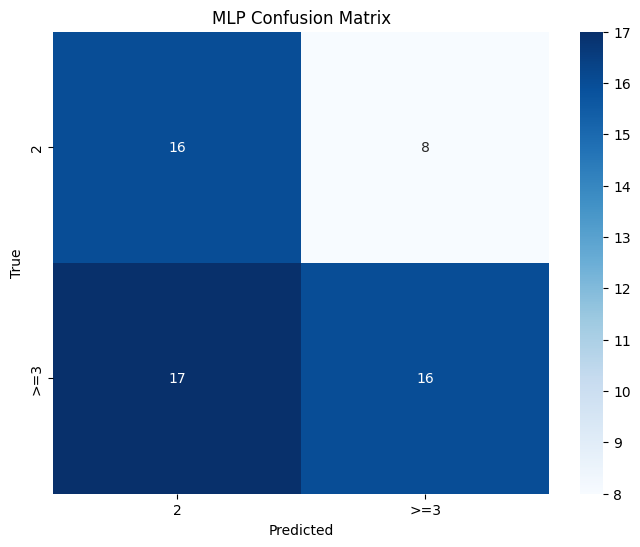

In [24]:
# MLP, my best friend
mlp = MLPClassifier(max_iter=1000, random_state=42, hidden_layer_sizes=(100, 50, 50, 50, 100, 50), activation='relu', solver='adam')
mlp.fit(X_train, y_train)
y_pred_mlp = mlp.predict(X_test)
mlp_accuracy = accuracy_score(y_test, y_pred_mlp)
mlp_report = classification_report(y_test, y_pred_mlp, output_dict=True)
mlp_cm = confusion_matrix(y_test, y_pred_mlp)

print("MLP Accuracy:", mlp_accuracy)
print("MLP Classification Report:\n", classification_report(y_test, y_pred_mlp))
plt.figure(figsize=(8, 6))
sns.heatmap(mlp_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['2', '>=3'], yticklabels=['2', '>=3'])
plt.title('MLP Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Random Forest Accuracy: 0.631578947368421
Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.54      0.88      0.67        24
           1       0.83      0.45      0.59        33

    accuracy                           0.63        57
   macro avg       0.69      0.66      0.63        57
weighted avg       0.71      0.63      0.62        57



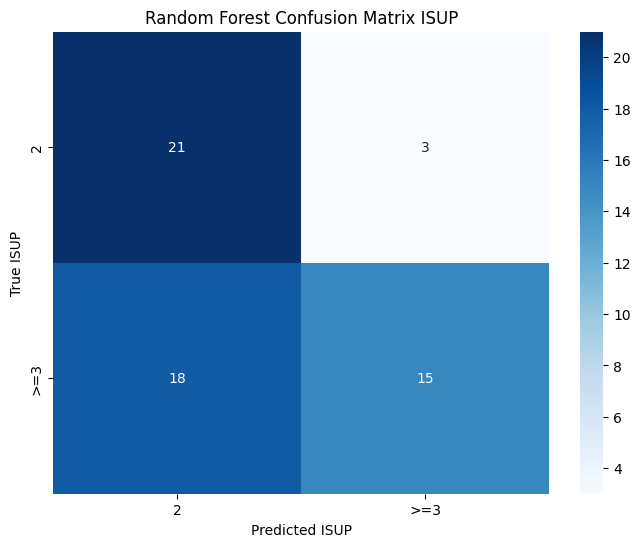

In [25]:
# Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
rf_accuracy = accuracy_score(y_test, y_pred_rf)
rf_report = classification_report(y_test, y_pred_rf, output_dict=True)
rf_cm = confusion_matrix(y_test, y_pred_rf)
print("Random Forest Accuracy:", rf_accuracy)
print("Random Forest Classification Report:\n", classification_report(y_test, y_pred_rf))
plt.figure(figsize=(8, 6))
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Blues', yticklabels=['2', '>=3'], xticklabels=['2', '>=3'])
plt.title('Random Forest Confusion Matrix ISUP')
plt.xlabel('Predicted ISUP')
plt.ylabel('True ISUP')
plt.show()


In [26]:
merge[isup].value_counts()

case_ISUP
2    144
3     70
5     40
4     27
Name: count, dtype: int64

In [27]:
pd.Series(y_pred_rf).value_counts()

0    39
1    18
Name: count, dtype: int64

In [28]:
y_test.value_counts()

ISUP>=3
1    33
0    24
Name: count, dtype: int64

In [77]:

pip install xgboost

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [71]:
import xgboost as xgb

XGBoostError: 
XGBoost Library (libxgboost.dylib) could not be loaded.
Likely causes:
  * OpenMP runtime is not installed
    - vcomp140.dll or libgomp-1.dll for Windows
    - libomp.dylib for Mac OSX
    - libgomp.so for Linux and other UNIX-like OSes
    Mac OSX users: Run `brew install libomp` to install OpenMP runtime.

  * You are running 32-bit Python on a 64-bit OS

Error message(s): ["dlopen(/Users/tizianapelamatti/Library/Python/3.9/lib/python/site-packages/xgboost/lib/libxgboost.dylib, 0x0006): Library not loaded: @rpath/libomp.dylib\n  Referenced from: <FBD6AEF9-AFAB-39D7-B881-755157DA0497> /Users/tizianapelamatti/Library/Python/3.9/lib/python/site-packages/xgboost/lib/libxgboost.dylib\n  Reason: tried: '/usr/local/opt/libomp/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/usr/local/opt/libomp/lib/libomp.dylib' (no such file), '/usr/local/opt/libomp/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/usr/local/opt/libomp/lib/libomp.dylib' (no such file)"]


## PCa Prediction

In [29]:
# Can we really answer the question?
merge.case_csPCa.unique()

# We can't because we only have positive cases, thus we can't train a model to predict negative cases

array([1])

FEATURE SELECTION PER MVL

questo mi serve perche così aggiungo la mia variabile target in binario

In [30]:
labels['ISUP>=3'] = (labels['case_ISUP'] >= 3).astype(int)

faccio un merge per allineare le righe 

In [31]:
merged = pd.merge(dataset, labels[['patient_ID', 'study_ID', 'ISUP>=3']], on=['patient_ID', 'study_ID'], how='inner')


ora imposto la variabile X, selezionando solo le colonne numeriche

In [32]:
X = merged.drop(columns=['study_ID', 'patient_ID', 'ISUP>=3'])
X = X.select_dtypes(include=[np.number]) 

rimuovo feature con varianza bassa e quelle con una correlazione alta

In [37]:
from sklearn.feature_selection import VarianceThreshold
var_thresh = VarianceThreshold(threshold=0.01)
X = X.loc[:, var_thresh.fit(X).get_support()]

mlp_cm = X.corr().abs()
var=mlp_cm.where(np.triu(np.ones(mlp_cm.shape), k=1).astype(bool))
to_drop_corr = [column for column in var.columns if any(var[column] > 0.90)]
X = X.drop(columns=to_drop_corr)

y = merged['ISUP>=3']

feature selection con RFE

LOGISTIC REGRESSION

In [43]:
lr = LogisticRegression(max_iter=1000, random_state=42)
rfe = RFE(estimator=lr, n_features_to_select=10)
rfe.fit(X_train_scaled, y_train)

RFE(estimator=LogisticRegression(max_iter=1000, random_state=42),
    n_features_to_select=10)

In [66]:
best_feat = X_train.columns[rfe.support_]
print("\n".join(f"- {f}" for f in best_feat))

- log-sigma-3-0-mm-3D_glszm_LargeAreaEmphasis
- wavelet-LLH_ngtdm_Coarseness
- wavelet-LHL_firstorder_90Percentile
- wavelet-LHL_firstorder_Maximum
- wavelet-LHH_glszm_LargeAreaEmphasis
- wavelet-LHH_gldm_LargeDependenceHighGrayLevelEmphasis
- wavelet-HLL_ngtdm_Coarseness
- wavelet-HLH_glrlm_LongRunLowGrayLevelEmphasis
- wavelet-HHL_ngtdm_Coarseness
- psa


In [67]:
from sklearn.feature_selection import SelectKBest, f_classif

selector = SelectKBest(score_func=f_classif, k='all')
selector.fit(X_train_scaled, y_train)
scores = selector.scores_

importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Score': scores
}).sort_values(by='Score', ascending=False)

# Seleziona con soglia furba
threshold = importance_df['Score'].mean()
selected_features = importance_df[importance_df['Score'] > threshold]['Feature'].tolist()

In [68]:
print("\n".join(f"- {f}" for f in selected_features))

- wavelet-LHH_firstorder_Minimum
- wavelet-LHH_ngtdm_Complexity
- wavelet-LHH_gldm_LargeDependenceHighGrayLevelEmphasis
- wavelet-LHH_firstorder_Maximum
- psad
- original_gldm_LargeDependenceLowGrayLevelEmphasis
- psa
- wavelet-LHL_gldm_LargeDependenceLowGrayLevelEmphasis
- wavelet-HLH_gldm_LargeDependenceLowGrayLevelEmphasis
- wavelet-LLL_firstorder_Skewness
- wavelet-LHH_firstorder_Kurtosis
- wavelet-LLH_firstorder_Maximum
- wavelet-LHH_firstorder_Entropy
- wavelet-LHL_ngtdm_Busyness
- log-sigma-5-0-mm-3D_glcm_ClusterShade
- wavelet-LLL_firstorder_Kurtosis
- wavelet-LHH_firstorder_10Percentile
- wavelet-HLH_glszm_LargeAreaLowGrayLevelEmphasis
- wavelet-LLH_ngtdm_Coarseness
- original_glrlm_LongRunLowGrayLevelEmphasis
- log-sigma-5-0-mm-3D_firstorder_Skewness
- wavelet-LLH_firstorder_Minimum
- wavelet-LHL_firstorder_Minimum
- wavelet-LHL_firstorder_Entropy
- wavelet-HLL_glszm_SizeZoneNonUniformityNormalized
- log-sigma-3-0-mm-3D_glcm_DifferenceEntropy
- wavelet-LLH_ngtdm_Complexity
- 

FEATURE SELECTION PER RANDOM FOREST

In [59]:
var_imp = rf.feature_importances_
feat_importance_df = pd.DataFrame({'Feature': X_train.columns, 'var_imp': var_imp})
feat_importance_df.sort_values(by='var_imp', ascending=False, inplace=True)

# 3. Seleziona le top 10
best_feat_rf = feat_importance_df['Feature'].iloc[:10].tolist()
print("\n".join(f"- {f}" for f in best_feat_rf))

- wavelet-LHH_gldm_LargeDependenceLowGrayLevelEmphasis
- wavelet-LHL_ngtdm_Busyness
- psa
- wavelet-LHH_ngtdm_Busyness
- wavelet-LHH_ngtdm_Complexity
- wavelet-LLH_firstorder_Maximum
- original_firstorder_Minimum
- log-sigma-3-0-mm-3D_gldm_SmallDependenceHighGrayLevelEmphasis
- wavelet-LHH_firstorder_Minimum
- original_firstorder_Skewness


In [62]:
sfm_rf = SelectFromModel(rf, threshold='mean', prefit=True)
selected_mask = sfm_rf.get_support()
useful_rf_features = X_train.columns[selected_mask].tolist()

print("Feature selezionate da SelectFromModel:")
for f in useful_rf_features:
    print("-", f)

Feature selezionate da SelectFromModel:
- original_shape_Flatness
- original_firstorder_10Percentile
- original_firstorder_Kurtosis
- original_firstorder_Maximum
- original_firstorder_Minimum
- original_firstorder_Skewness
- original_glcm_Correlation
- original_glcm_Idm
- original_glrlm_LongRunLowGrayLevelEmphasis
- original_gldm_LargeDependenceLowGrayLevelEmphasis
- original_ngtdm_Busyness
- log-sigma-3-0-mm-3D_firstorder_90Percentile
- log-sigma-3-0-mm-3D_firstorder_Entropy
- log-sigma-3-0-mm-3D_firstorder_Minimum
- log-sigma-3-0-mm-3D_firstorder_Skewness
- log-sigma-3-0-mm-3D_glcm_Autocorrelation
- log-sigma-3-0-mm-3D_glcm_Contrast
- log-sigma-3-0-mm-3D_glcm_DifferenceVariance
- log-sigma-3-0-mm-3D_glszm_SmallAreaLowGrayLevelEmphasis
- log-sigma-3-0-mm-3D_gldm_LargeDependenceLowGrayLevelEmphasis
- log-sigma-3-0-mm-3D_gldm_SmallDependenceHighGrayLevelEmphasis
- log-sigma-3-0-mm-3D_ngtdm_Busyness
- log-sigma-3-0-mm-3D_ngtdm_Strength
- log-sigma-5-0-mm-3D_firstorder_10Percentile
- log-